In [1]:
# This notebook contains the code for a classifier on the CIFAR-10 dataset.
# The classifier is a convolutional neural network built primarily using tools from the PyTorch library.
#
# I have organized this notebook as follows:
#
# PREPARATION CELL 1: Importing libraries and packages
# PREPARATION CELL 2: Transformation chain for converting the CIFAR-10 dataset
# PREPARATION CELL 3: Downloading and converting the CIFAR-10 dataset
# PREPARATION CELL 4: Iterators for loading images from the training and test sets
# PREPARATION CELL 5: Convolution neural network architecture
# PREPARATION CELL 6: Loss and optimization functions
#    TRAINING CELL  : Training the network on the CIFAR-10 training set
#     TESTING CELL 1: Matching test images one batch at a time
#     TESTING CELL 2: Computing the network's overall matching accuracy
#     Testing CELL 3: Computing the network's per-class matching accuracy
#
# The notebook is organized so that the training session occurs after the necessary
# preparations have been executed and is followed by three separate tests that each measure
# the trained network's accuracy.
# I have provided commentary throughout this notebook, and I would be happy to discuss my approach
# to this assignment further.

In [2]:
## PREPARATION CELL 1
## Imports all libraries and packages used in this notebook

# PyTorch
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Matplotlib
import matplotlib.pyplot as plt

# Numpy
import numpy as np

In [3]:
## PREPARATION CELL 2
## Prepares a chain of transformations to convert the CIFAR-10 dataset into tensors of normalized values

cifar10transform = transforms.Compose(
    
            [
                # Transformation 1:
                # Convert PIL image data with shape (Height x Width x Channel) and integer values [0, 255] 
                # into tensors with shape (Channel x Height x Width) and float values [0.0, 1.0]
                transforms.ToTensor(),
                
                # Transformation 2:
                # Normalize the values of the converted CIFAR-10 dataset 
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ]
)

# Additional comments:
# The means and standard deviations I used for normalization were found online.
# I used these values again for the unnormalization.

In [4]:
## PREPARATION CELL 3
## Downloads and converts the training and test sets of the CIFAR-10 dataset for use in the Convolution Neural Network

# Both sets are saved in a folder 'data' in the notebook's directory
  # (is there a way to create a folder in the directory from within a notebook using Python?)

# Downloads, transforms, and stores the CIFAR-10 training set
trainingset = CIFAR10(root='./data', train=True, download=True, transform=cifar10transform)

# Downloads, transforms, and stores the CIFAR-10 test set
testset = CIFAR10(root='./data', train=False, download=True, transform=cifar10transform)

# Defines a list of the 10 classes of images in the CIFAR-10 dataset, indexed 0-9
# airplane (0), automobile (1), bird (2), cat (3), deer (4), dog (5), frog (6), horse (7), ship (8), truck (9)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Additional comments:
# Later on in the training and testing sections, the term 'labels' becomes somewhat interchangeable with the indices 
# of the classes of images in the CIFAR-10 dataset.

Files already downloaded and verified
Files already downloaded and verified


In [5]:
## PREPARATION CELL 4
## Prepares iterators for the training and test datasets

# Defines an iterator that returns images from the training set in randomly selected batches of 4, w/o replacement
# Will feed images to the network during training
trainingloader = DataLoader(trainingset, batch_size=4, shuffle=True)

# Defines an iterator that returns images from the test set in randomly selected batches of 4, w/o replacement
# Will feed images to the network during testing, following training
testloader = DataLoader(testset, batch_size=4, shuffle=True)

# Additional comments:
# I tested out larger batch sizes (8 and 10), but those both led to a consistent reduction in accuracy.

In [6]:
## PREPARATION CELL 5
## Prepares the architecture of the convolutional neural network

# Defines a subclass of networks called 'CNN', based on the torch.nn.Module class
class CNN(nn.Module):
    
    # Defines the network's building blocks within the 'CNN' class's constructor
    # 3 convolutional layers, 3 max pooling layers (identical), 3 fully-connected layers
    # Not included here: flatten layer (x.view below), rectified linear unit activation (F.relu below)
    def __init__(self):
        
        super(CNN, self).__init__()                      
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)      # Convolution 1:  3-channel input -> 16-channel output
                                                         #                 3x3 filter, stride: 1, zero-padding: 1   
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)     # Convolution 2: 16-channel input -> 32-channel output
                                                         #                 3x3 filter, stride: 1, zero-padding: 1 
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)     # Convolution 3: 32-channel input -> 64-channel output
                                                         #                 3x3 filter, stride: 1. zero-padding: 1
        self.pool = nn.MaxPool2d(2, 2)                   # 2D Max Pooling 1,2,3: 2x2 window, stride: 2
                                                         #
        self.fc1 = nn.Linear(64*4*4, 512)                # Fully-Connected 1: 1024-width input -> 512-width output
        self.fc2 = nn.Linear(512, 256)                   # Fully-Connected 2:  512-width input -> 256-width output
        self.fc3 = nn.Linear(256, 10)                    # Fully-Connected 3:  512-width input ->  10-width output
        
    # Defines the sequence of the network's algorithm within the 'CNN' class's forward function
    # The full sequence is mapped out below to the right
    def forward(self, x):                                
                                                         #    INPUT (3x32x32 image data)
        x = self.pool(F.relu(self.conv1(x)))             # -> Convolution 1 -> ReLU activation -> 2D Max Pooling 1
        x = self.pool(F.relu(self.conv2(x)))             # -> Convolution 2 -> ReLU activation -> 2D Max Pooling 2
        x = self.pool(F.relu(self.conv3(x)))             # -> Convolution 3 -> ReLU activation -> 2D Max Pooling 3
        x = x.view(-1, 64*4*4)                           # -> Flatten/Reshape
        x = F.relu(self.fc1(x))                          # -> Fully-Connected 1 -> ReLU activation
        x = F.relu(self.fc2(x))                          # -> Fully-Connected 2 -> ReLU activation
        x = self.fc3(x)                                  # -> Fully-Connected 3
        return x                                         # -> OUTPUT (1x10 probability tensor)

# Defines an object of the 'CNN' class that will serve as our convolutional neural network
cnn = CNN()

# Additional comments:
# Having a filter-size of 3, stride of 1, and zero-padding of 1 means that the outputs of the convolution layers
# will have the same dimensions as their inputs.
# Having a window-size of 2 and stride of 2 means that the outputs of the max pooling layers will have dimensions that
# are half the size of the dimensions of their inputs.
# For these reasons, the input for the first fully-connected layer will be 64x4x4. The dimensions of the original
# channels (32x32) are halved three times.

In [7]:
## PREPARATION CELL 6
## Prepares the tools for computing and reducing the network's error

# Defines a loss function that computes cross-entropy loss, a common measure of performance for classification networks
loss_function = nn.CrossEntropyLoss()

# Defines an optimization function that is a Stochastic Gradient Descent (SGD) with Nesterov momentum
# Learning Rate: 0.001
# Nesterov Momentum: 0.9
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9, nesterov=True)

# Additional comments:
# I tested out a higher learning rate (0.01), but that led to a consistent reduction in accuracy.

In [8]:
## TRAINING CELL
## Trains the convolutional neural network using the framework prepared thus far

# Loop over our data iterator, and feed the inputs to the network and optimize

# For-loop that iterates over the entire training set 5 times/epochs
# 'epoch' increments 0 to 4
for epoch in range(5):                                         
    
    running_loss = 0.0                                 # Sets loss to 0.0 at the start of every epoch
    
    # Nested for-loop that iterates over the training set in batches of 4
    # Feeds inputs to the network, computes loss, backprops, and optimizes
    # 'batch' increments 0 to 6250 (1 every 1000 batches)
    for batch, data in enumerate(trainingloader, 0): 
       
        inputs, labels = data                          # Separates the batch into the inputs and their correct labels
        
        optimizer.zero_grad()                          # Zeroes the parameter gradients to prevent accumulation
        
        outputs = cnn(inputs)                          # Feeds image inputs into the network (forward propagation)
        
        loss = loss_function(outputs, labels)          # Computes the loss between the outputs and target labels
        
        loss.backward()                                # Backpropagation
        
        optimizer.step()                               # Updates the SGD parameters
        
        running_loss += loss.item()                    # Adds to the total loss for the current 1000 batches
        
        if batch % 2000 == 1999:                       # Reports the average loss for every 1000 batches
            print('Epoch[%d] Batch[%5d] Loss[%.3f]' %
                  (epoch + 1, batch + 1, running_loss / 2000))
            running_loss = 0.0                         # Sets loss back to 0.0 after reporting
            
print('Finished Training')


# Additional comments:
# This training session takes 15-20 minutes to complete on my computer.
# I am currently running Mojave 10.14 on my MacBook, so I am unfortunatey unable to run any processes 
# in Python on my NVIDIA GPU through CUDA. 

Epoch[1] Batch[ 2000] Loss[2.105]
Epoch[1] Batch[ 4000] Loss[1.695]
Epoch[1] Batch[ 6000] Loss[1.525]
Epoch[1] Batch[ 8000] Loss[1.414]
Epoch[1] Batch[10000] Loss[1.313]
Epoch[1] Batch[12000] Loss[1.239]
Epoch[2] Batch[ 2000] Loss[1.131]
Epoch[2] Batch[ 4000] Loss[1.096]
Epoch[2] Batch[ 6000] Loss[1.060]
Epoch[2] Batch[ 8000] Loss[1.042]
Epoch[2] Batch[10000] Loss[1.002]
Epoch[2] Batch[12000] Loss[0.975]
Epoch[3] Batch[ 2000] Loss[0.883]
Epoch[3] Batch[ 4000] Loss[0.872]
Epoch[3] Batch[ 6000] Loss[0.869]
Epoch[3] Batch[ 8000] Loss[0.831]
Epoch[3] Batch[10000] Loss[0.846]
Epoch[3] Batch[12000] Loss[0.817]
Epoch[4] Batch[ 2000] Loss[0.701]
Epoch[4] Batch[ 4000] Loss[0.728]
Epoch[4] Batch[ 6000] Loss[0.738]
Epoch[4] Batch[ 8000] Loss[0.715]
Epoch[4] Batch[10000] Loss[0.738]
Epoch[4] Batch[12000] Loss[0.720]
Epoch[5] Batch[ 2000] Loss[0.583]
Epoch[5] Batch[ 4000] Loss[0.602]
Epoch[5] Batch[ 6000] Loss[0.630]
Epoch[5] Batch[ 8000] Loss[0.606]
Epoch[5] Batch[10000] Loss[0.646]
Epoch[5] Batch

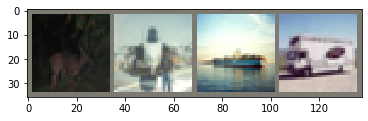

Actual:   deer airplane  ship truck
Predicted:    cat airplane  ship airplane


In [12]:
## TESTING CELL 1
## This is an simple, repeatable test to see how well the trained network can classify a batch of test images

# Defines a function that converts images back from tensors into their original PIL Image form
def imshow(img):
    
    img = torchvision.utils.make_grid(img)       # Arranges images into a grid
    img[0] = img[0] * 0.2023 + 0.4914            # Unnormalizes the images using the same means and standard deviations 
    img[1] = img[1] * 0.1994 + 0.4822
    img[2] = img[2] * 0.2010 + 0.4465
    npimg = img.numpy()                          # Converts tensor values to numpy values
    plt.imshow(np.transpose(npimg, (1, 2, 0)))   # Reshapes image data back from (C x H x W) to (H x W x C)
    plt.show()                                   # Graph the images


# Iterates once through the test loader to select a batch of 4 random test images
dataiter = iter(testloader)                      
images, labels = dataiter.next()

# Graphs the 4 test images
imshow(images)                                   

# Prints the actual class of each test image
# 'j' here refers to the indices 0-4 of the batch of 4 images
print('Actual: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Feeds the 4 test images into the network
outputs = cnn(images)

# Defines 'predicted' as a tensor consisting of the indices of the predicted images in the current batch
# torch.max also returns the tensor of the probability values, but that is discarded by the blank identifier 
_, predicted = torch.max(outputs, 1)

# Prints the network's predicted class for each image
# 'j' here refers to the indices 0-4 in the list of 4 predicted labels
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [10]:
## TESTING CELL 2: Overall Network Accuracy
## This test calculates the trained network's overall accuracy at matching images across the entire CIFAR-10 test set
# I have consistently achieved values in the range of 70-72%

# Sets these two variables at zero to start
correct = 0
total = 0

# This is a PyTorch-specific wrapper that prevents PyTorch objects from using memory to keep track of their history
with torch.no_grad():
    
    # For-loop that iterates through the entire test set of 10000 images, a batch of 4 at a time
    for data in testloader:
        
        # Separates the test set into the images and their correct labels
        images, labels = data
        
        # Feeds every test image into the network
        outputs = cnn(images)
        
        # Defines 'predicted' as a tensor consisting of the indices of the predicted labels in the current batch
        # torch.max also returns the tensor of the probability values, but that is discarded by the blank identifier
        _, predicted = torch.max(outputs.data, 1)
        
        # Adds up the number of labels, eventually to 10000
        total += labels.size(0)
        
        # Adds up the number of labels correctly predicted by the network
        correct += (predicted == labels).sum().item()

# Computes the percentage of correct predictions made by the network
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %


In [11]:
## TESTING CELL 3: Network Accuracy Per CIFAR-10 Class
## This test calculates the trained network's accuracy at matching images in each class in the CIFAR-10 test set

# Defines two 10-item lists, and sets all items to 0. to start
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# This is a PyTorch-specific wrapper that prevents PyTorch objects from using memory to keep track of their history
with torch.no_grad():
    
    # For-loop that iterates through the entire test set of 10000 images
    for data in testloader:
        
        # Separates the test set into the images and their correct labels
        images, labels = data
        
        # Feeds every test image into the network
        outputs = cnn(images)
        
        # Defines 'predicted' as a tensor consisting of the indices of the predicted labels in the current batch
        # torch.max also returns the tensor of the probability values, but that is discarded by the blank identifier
        _, predicted = torch.max(outputs, 1)
        
        
        # Defines a tensor of conditions (True or False) for the predictions in the current batch
        c = (predicted == labels).squeeze()
        
        # Nested for-loop that iterates over each batch of 4 test images
        for i in range (4):
            
            # Returns the correctly numbered label at each position in the batch
            label = labels[i]
            # When a class label 0-9 is returned by 'label', and the prediction for that label in 'c' matches,
            # 1 is added to the value at that index in class_correct
            class_correct[label] += c[i].item()
            # When a class label 0-9 is returned by 'label', 1 is added to the value at that index in class_total
            class_total[label] += 1

# For-loop that prints the results for each class, indexed 0 to 9            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 81 %
Accuracy of automobile : 79 %
Accuracy of  bird : 68 %
Accuracy of   cat : 56 %
Accuracy of  deer : 69 %
Accuracy of   dog : 55 %
Accuracy of  frog : 74 %
Accuracy of horse : 74 %
Accuracy of  ship : 88 %
Accuracy of truck : 79 %
